#Internet-of-Things Classification Challenge
Activity recognition in a home enviornment is an important problem with applications to elder care, safety/security, and home automation. This challenge studies data, models, and techniques that can best leverage camera data to predict activities in a kitchen. The data was collected at the University of Chicago in a mock kitchen. It consists of a series of videos, from multiple angles, of different interactions with smart home devices.

The objective of the first phase of this assignment is to get started with a basic model. You will familiarize yourself with the following: (1) how to access the dataset, (2) how to extract basic features from the dataset, (3) how to train model on these features, and (4) how to submit your results to our model scoring leaderboard.

This first phase will have less flexibility than future ones. We’d like to understand the best we can achieve using only Facebook's VideoPose3D package for featurization. That is, you should not use any other video/image feature, but you are allowed to subsample video frames, and select any subset of 3-D Keypoints from this package as appropriate. While the 3-D keypoint packages also provide ‘confidence’ values for tracking, these are not to be used yet. 

### Setup 1. Accessing The Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Once you mount the drive, you should be able to access the directory as you would in standard Python

In [2]:
import os
os.listdir('/content/drive/My Drive/IOT Classification Challenge/')

['VideoPose3D',
 'Evaluation_Dataset',
 'Dataset_1',
 'data-washer.zip',
 'Copy of data-washer.zip']

In [3]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'

os.listdir(DATASET)

['put_back_item',
 'open_close_fridge',
 'screen_interaction',
 'take_out_item',
 'no_interaction']

In [4]:
from glob import glob
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.*'))]
result[:10]

['/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_2_1613086149_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_2.mkv',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253.wav',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_1_1613086093.wav',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200.wav',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_

In [5]:
def initialize_dataset():
  result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]  # extract all the mp4 file.
  labels = [r.split('/')[7] for r in result]   #labels are the interactions with refrigerator.
  return list(zip(labels, result))

(initialize_dataset())[:10]

[('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_2_1613086149_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_5_1613086310_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_1_1613086093_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/4/put_back_item_7_1616180920_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/pu

## Setup 2. Working with Video Data

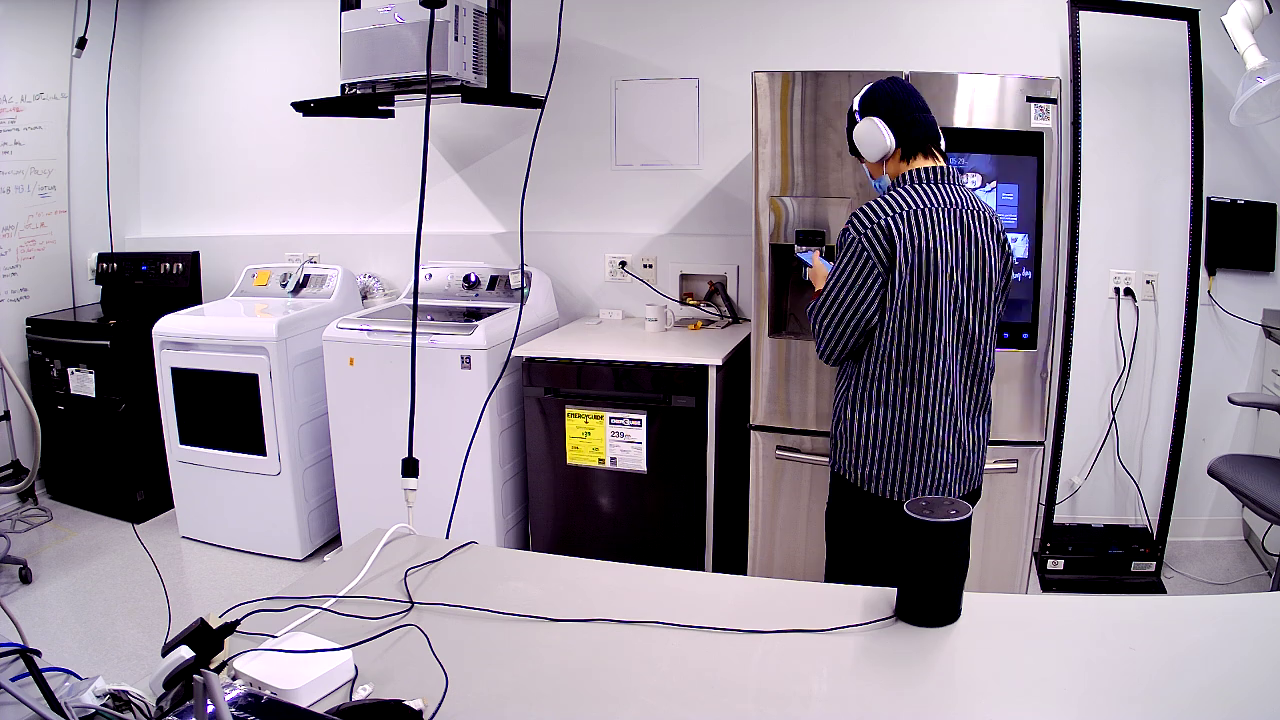

In [6]:
import cv2
from google.colab.patches import cv2_imshow

label, path = initialize_dataset()[0] #get first video, label is "put_back_item",path is the ".../...mp4"

cap = cv2.VideoCapture(path) #open the video
while(cap.isOpened()):
  ret, frame = cap.read() # ret is True/False of reading video correctly, frame is pixel matrix.
  if ret == True:
    cv2_imshow(frame) # return the first frame of original picture
    break



We can also look at each individual frame to get a better understanding of the data. Each frame is a 720x1280x3 numpy array:

In [9]:
frame.shape

(720, 1280, 3)

In [ ]:
import numpy as np

In [ ]:
np.max(frame[1])

255

As a more complicated example, the following code aggregates the first 100 frames into a 4D numpy array (i.e., stacks each frame into a single array):

In [ ]:
import pandas as pd
import numpy as np
cap = cv2.VideoCapture(path) #open the video

cnt = 0
framelist = []

while(cap.isOpened()):
  ret, frame = cap.read()

  if cnt >= 100:  #
    break

  if ret == True:
    framelist.append(frame)
  else:
    raise ValueError('Video malformated or too short')
  
  cnt += 1

first_100_frames = np.stack(framelist)
first_100_frames.shape


## Setup 3. VideoPose3D
In the first phase, you will use pretrained models from Facebook's VideoPose3D library:
https://github.com/facebookresearch/VideoPose3D
The library takes as input videos of human activities, identifies "keypoints" on the human body, and estimates the 3D position of those keypoints. 

The first step is to install all of the prerequisites.


In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

After, installing the pre-requisites we will demonstrate how to use VideoPose3d. The following code changes directories into the VideoPose3d folder and runs inference on a demo video.

In [ ]:
%cd /content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/

We've placed one demo video in the VideoPose3D folder and the following code runs inference on that video. It takes about 2 mins to complete.

In [ ]:
!python infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir outputs \
    --image-ext mp4 \
    inputs/

After running this code, the outputs are stored in the output folder.

In [ ]:
%cd /content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/outputs
os.listdir('.')

/content/drive/.shortcut-targets-by-id/1qw4qbCL-wVmiuxuHCZRtRcRZs8YW1swx/IOT Classification Challenge/VideoPose3D/inference/outputs


['test.mp4.npz']

These outputs can be loaded into numpy as a standard numpy array. We will show a brief tutorial of how to use this data structure.

In [ ]:
data = np.load('test.mp4.npz',allow_pickle=True)
for d in data.files:
  print(d)

boxes
segments
keypoints
metadata


The main features that we want you to work with are keypoints. The API is a little difficult to use so we have some demo code to retrieve the keypoints

In [ ]:
def extract_trajectories(keypoints):
  trajectory = []
  for _,k in keypoints:
    if len(k) !=0: #removes data where nothing is happening
      three_d_point = k[0,[0,1,3],:] #understand this code!!! look it up in the documentation
      trajectory.append(three_d_point)

  return trajectory


traj = extract_trajectories(data['keypoints'])

There are 17 keypoints and each keypoint is a 3d point in space. For example, to grab the first time-step, we get the following 3x17 vector

In [ ]:
traj[0]

array([[1.2498834e+03, 1.2537076e+03, 1.2527516e+03, 1.2728293e+03,
        1.2747416e+03, 1.2690051e+03, 1.2565759e+03, 1.2508394e+03,
        1.2288495e+03, 1.1829574e+03, 1.2517955e+03, 1.2690051e+03,
        1.2212008e+03, 1.2623125e+03, 1.2345859e+03, 1.1810453e+03,
        1.1800891e+03],
       [1.3659172e+02, 1.2892342e+02, 1.2988196e+02, 1.4521857e+02,
        1.4138441e+02, 2.5353342e+02, 2.5257489e+02, 4.0402396e+02,
        4.3469717e+02, 5.6218280e+02, 5.5115959e+01, 2.4394804e+02,
        5.9189746e+02, 3.7335074e+02, 4.2511179e+02, 5.6793402e+02,
        5.6793402e+02],
       [9.3154505e-02, 1.5066868e-01, 1.0222093e-01, 1.6204594e-01,
        1.1094532e-01, 9.0640843e-02, 7.4473619e-02, 2.8256783e-02,
        3.9042361e-02, 8.7578058e-02, 6.2662855e-02, 8.6169736e-03,
        1.0698004e-02, 7.6038241e-03, 1.0091185e-02, 2.8308963e-02,
        4.2222437e-02]], dtype=float32)

We can plot one of the dimensions over time to understand how the data looks. For example, the following code plots the 2 of the key point dimensions on a plane

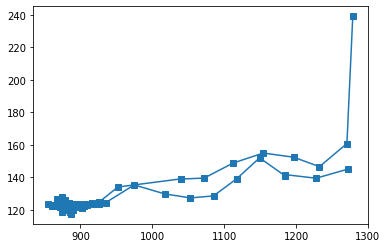

In [ ]:
import matplotlib.pyplot as plt

plot_data = np.stack(traj)
plt.plot(plot_data[:,0,3],plot_data[:,1,3], 's-')
#plot_data.shape

To get this to work on your own notebook, you will have to download the facebook repository and put it in your own google drive. This has to do with "write" permissions.

## TODO 1. Preprocessing
Video activity classification is much easier if all of the videos have the same number of frames. However, notice that the data that we gave you has videos of different lengths.  

Your first TODO is to write a preprocessing function that iterates through all of the videos and subsamples the frames to keep only 100 of them per video. The function should store these subsampled videos in a separate directory. 

You may subsample the video in any way you choose. You may also handle videos shorter than a 100 frames in any way you choose (i.e., blank frames or duplicate the last frame).

This tutorial on writing videos with OpenCV should be helpful:
https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

In [ ]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'

os.listdir(DATASET)

['put_back_item',
 'open_close_fridge',
 'screen_interaction',
 'take_out_item',
 'no_interaction']

In [ ]:
from glob import glob
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.*'))]
result[:4]

['/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_2_1613086149_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_2.mkv',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253.wav']

In [ ]:
def initialize_dataset():
  result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]
  labels = [r.split('/')[7] for r in result]
  return list(zip(labels, result))

initialize_dataset()[:4]

[('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_2_1613086149_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_5_1613086310_1.mp4')]

In [ ]:
!pip install scipy==1.5

In [ ]:
def get_frames(path, frameskip = 1, greyscale = False):

  cap = cv2.VideoCapture(path) #open the video

  cnt = 0
  framelist = []

  #extracts frames according to frameskip
  while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == True:
      if cnt%frameskip == 0:
        framelist.append(frame)
    else:
      break

    cnt += 1

  #greyscaling video
  if greyscale:
    greyer = lambda t: cv2.cvtColor(t, cv2.COLOR_BGR2GRAY)
    framelist = np.array([greyer(x) for x in framelist])
  
  return framelist

In [ ]:
grey_frames = get_frames(path,frameskip = 2,greyscale = True)

Note on using the abs diff function:

The image is from using frame by frame subtraction:
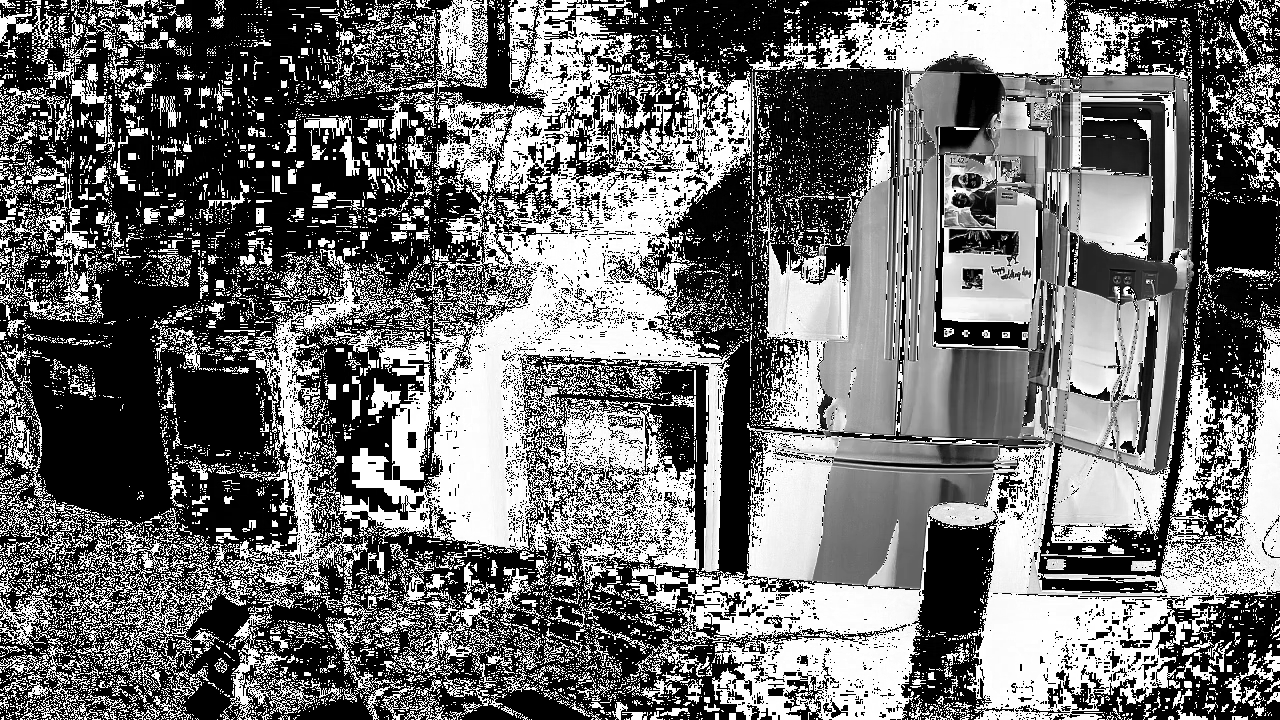

The following is by using abs diff between the current frame and the first frame:
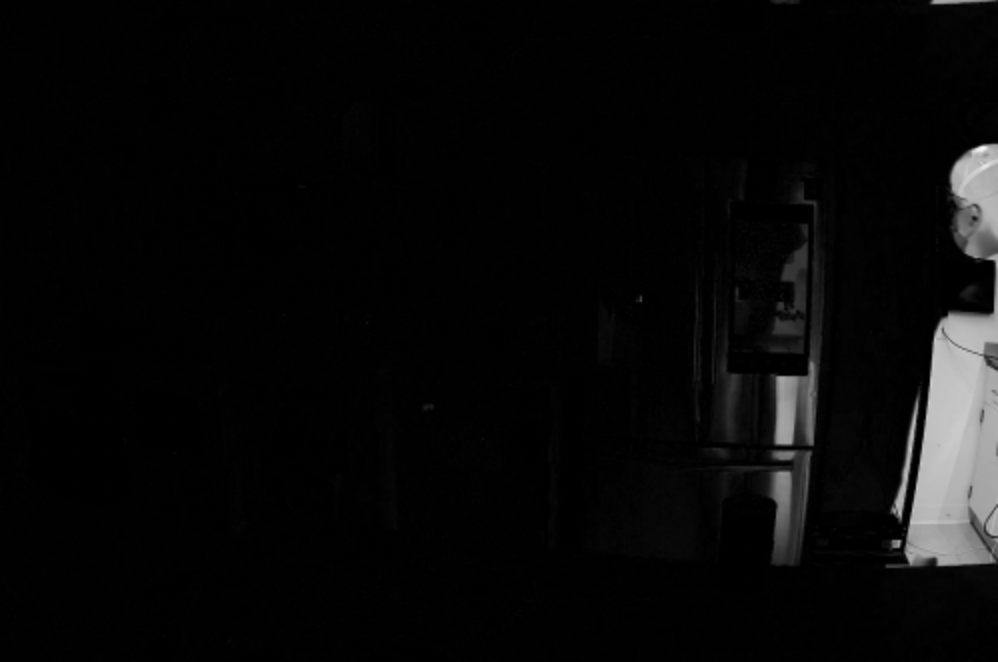

Note on best_100_frame_seg_histogram_combined method:

This method works better than the previous version of the method. Previously, it had detected human movement too early for video 110 at frame 1 when the actual human entered in frame 25. The previous method just involved calculating the absolute difference between each frame and the first frame (frame_delta), checking if this difference is greater than a threshold, and saving the matrix entries into boolean_diff = frame_delta > thres. The previous method only checked if there are more than some # of entries in boolean_diff. But a more accurate method is implemented by creating 20 x 20 unit bins spanning the whole image matrix (of dimension 1280 by 720 ), calculating which bins are occupied by the pixels of true boolean_diff (above the threshold of 150), and saving these counts to a map (bin_histogram). Then, there must be above 100 counts in a bin that occurs at least twice in order for this frame to be significant. 

In [ ]:
# note : run this first
!pip install scipy==1.5

In [ ]:
bin_orig_map = {}
ind=0

for i in range(66): # 1280 total
  for j in range(38): # 720 total
    bin_orig_map[(i,j)] = ind
    ind = ind+1

from scipy import stats

binx = 20*np.arange(65)
biny = 20*np.arange(37)

def best_100_frame_seg_histogram_combined(grey_frames):
  # step 1 
  ind = 0

  thres = 150

  frame_coords = {}

  frame_coords_x = {}
  frame_coords_y = {}

  number_diffs = {}

  firstFrame = grey_frames[0]

  frame_no = 0 

  for frame in grey_frames:
    frame_no = frame_no + 1
    if ind==0:
      prev_frame = frame
      ind = ind+1
      continue

    diff = prev_frame - frame
    diff_abs = abs(diff)

    #cv2_imshow(diff_abs)

    frame_delta = cv2.absdiff(firstFrame, frame)

    #if 10 <ind < 16:
      #cv2_imshow(frame_delta)

    # boolean greater than threshold
    boolean_diff = frame_delta > thres #diff_abs > thres

    where_diff = np.where(boolean_diff)

    #number_diffs[ind] = len(where_diff[0])

    

    coords = []
    coords_x = []
    coords_y= []
    for (x, y) in zip(where_diff[0], where_diff[1]):
        #print((x, y))
        coords_x.append(x)
        coords_y.append(y)
        coords.append((x,y))

        # compare distance with average?

    # direct analysis here 
    len_coords = len(where_diff[0])
    if len_coords> 10:
      sb = stats.binned_statistic_2d(coords_x, coords_y, None, 'count', bins=[binx, biny], expand_binnumbers=True)
      bin_arrs = sb[3]

      bin_x = bin_arrs[0]
      bin_y = bin_arrs[1]

      bin_histogram = {}

      for ind in range(len(bin_x)):
        pair = (bin_x[ind], bin_y[ind])
        #print("pair is ", pair)
        orig_index = bin_orig_map[pair]
        if bin_histogram.get(orig_index) ==None:
          bin_histogram[orig_index]=1
        else:
          bin_histogram[orig_index]= bin_histogram[orig_index]+1
      # if the counts within bin_histogram are greater than 100
      tot_v_count =0
      for k in bin_histogram:
        v = bin_histogram[k]
        
        if v > 100:
          #print(v)
          tot_v_count = tot_v_count+1 

      if tot_v_count > 2:
        print("frame number returned is:", frame_no)
        return(frame_no)


    # analyze coordinates
    #frame_coords[ind] = coords
    #frame_coords_x[ind] = coords_x
    #frame_coords_y[ind] = coords_y

    ind = ind+1
    prev_frame=frame

  print("frame number returned is 0")
  return(0) # return if none found

In [ ]:
all_videos = initialize_dataset()[0:114] + initialize_dataset()[115:169] + initialize_dataset()[170:] #to avoid re-running initialized_dataset too much, also cut out video[114 & 169] as it's 14 & 5 minutes long


In [ ]:
len(all_videos)

218

In [ ]:
def write_video(label):
    out = cv2.VideoWriter('SubSampled_' + path.split('/')[9],
                        cv2.VideoWriter_fourcc('M', 'J' ,'P', 'G'), 10, (subsample_video.shape[2], subsample_video.shape[1]))

    for frame in subsample_video:
        out.write(frame)

In [ ]:
%cd /content/subsample_frames

/content/subsample_frames


Below code: subsample video every other frame (frameskip=2) 

In [ ]:
#Looping the above processes for all videos

#all_videos = initialize_dataset()[0:114] + initialize_dataset()[115:169] + initialize_dataset()[170:] #to avoid re-running initialized_dataset too much, also cut out video[114 & 169] as it's 14 & 5 minutes long

for video in range(len(all_videos)):

  print('processing video', video, 'out of', len(all_videos)-1)

  label, path = all_videos[video] #get video
  print(path)

  grey_frames = get_frames(path, frameskip=2, greyscale=True) #get frames, skip every x frame, greyscale it

  best_segment = best_100_frame_seg_histogram_combined(grey_frames) #select best 100 frames

  color_frames = get_frames(path, frameskip=2, greyscale=False) #make sure frameskip matches from above

  subsample_video = np.stack(color_frames[best_segment:best_segment+100]) #crop colour video into the best 100 frames

  write_video(label)

processing video 1 out of 217
/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_1.mp4
frame number returned is: 2
processing video 2 out of 217
/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253_1.mp4
frame number returned is: 2
processing video 3 out of 217
/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_5_1613086310_1.mp4
frame number returned is: 2
processing video 4 out of 217
/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_1_1613086093_1.mp4
frame number returned is: 2
processing video 5 out of 217
/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/4/put_back_item_7_1616180920_1.mp4
frame number returned is: 30
processing video 6 out of 217
/content/drive/My Drive/IOT Classification Challenge/D

## TODO 2. Featurization
In the next step, you will write a function that applies the VideoPose3D model to each subsampled video. The example above will help you understand how to use the library and what the outputs are. The output should be a directory of .npz files corresponding to the features. 

In [ ]:
%cd /content/drive/My Drive/Preprocess_Videos/

/content/drive/My Drive/Preprocess_Videos


In [ ]:
!python infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir outputs \
    --image-ext mp4 \
    inputs/

Streaming output truncated to the last 5000 lines.
Frame 39 processed in 0.541s
Frame 40 processed in 0.539s
Frame 41 processed in 0.542s
Frame 42 processed in 0.538s
Frame 43 processed in 0.533s
Frame 44 processed in 0.541s
Frame 45 processed in 0.535s
Frame 46 processed in 0.536s
Frame 47 processed in 0.531s
Frame 48 processed in 0.540s
Frame 49 processed in 0.539s
Frame 50 processed in 0.545s
Frame 51 processed in 0.532s
Frame 52 processed in 0.535s
Frame 53 processed in 0.539s
Frame 54 processed in 0.537s
Frame 55 processed in 0.538s
Frame 56 processed in 0.540s
Frame 57 processed in 0.534s
Frame 58 processed in 0.533s
Frame 59 processed in 0.538s
Frame 60 processed in 0.527s
Frame 61 processed in 0.529s
Frame 62 processed in 0.526s
Frame 63 processed in 0.526s
Frame 64 processed in 0.532s
Frame 65 processed in 0.529s
Frame 66 processed in 0.531s
Frame 67 processed in 0.538s
Frame 68 processed in 0.539s
Frame 69 processed in 0.539s
Frame 70 processed in 0.542s
Frame 71 processed in

In [ ]:
DATASET = '/content/drive/My Drive/iot_dataset/Preprocess_Videos/outputs'
os.listdir(DATASET)[:4]

['SubSampled_put_back_item_3_1613086200_1.mp4.npz',
 'SubSampled_put_back_item_4_1613086253_1.mp4.npz',
 'SubSampled_put_back_item_5_1613086310_1.mp4.npz',
 'SubSampled_put_back_item_1_1613086093_1.mp4.npz']

In [ ]:
%cd /content/drive/My Drive/iot_dataset/Preprocess_Videos/outputs
os.listdir('.')[:4]

/content/drive/My Drive/iot_dataset/Preprocess_Videos/outputs


['SubSampled_put_back_item_3_1613086200_1.mp4.npz',
 'SubSampled_put_back_item_4_1613086253_1.mp4.npz',
 'SubSampled_put_back_item_5_1613086310_1.mp4.npz',
 'SubSampled_put_back_item_1_1613086093_1.mp4.npz']

In [ ]:
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.npz'))]
videos = [r.split('/')[7] for r in result]

In [ ]:
data = []
result_num = []
for video in videos:
    data = np.load(video,allow_pickle = True)
    trajectory = extract_trajectories(data["keypoints"])
    result_num.append(trajectory)

In [ ]:
len(result_num)

218

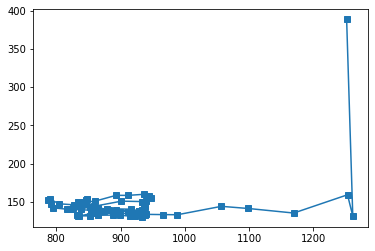

In [ ]:
import matplotlib.pyplot as plt

plot_data = np.stack(result_num[1])
plt.plot(plot_data[:,0,3],plot_data[:,1,3], 's-')
#plot_data.shape

## TODO 3. Create a Dataset
Next, you will aggregate all of this preprocessed data into numpy arrays that can be used for machine learning. You will now create a training dataset and validation dataset. 

Hint: the tricky part here will be to make sure you can figure out what the label for the file should be!


In [ ]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'
os.listdir(DATASET)

['put_back_item',
 'open_close_fridge',
 'screen_interaction',
 'take_out_item',
 'no_interaction']

In [ ]:
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]  # extract all the mp4 file.
labels = [r.split('/')[7] for r in result]


In [ ]:
result[114]

'/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/screen_interaction/5/screen_interaction_7_1614113152_1.mp4'

In [ ]:
result[169]

'/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/take_out_item/5/take_out_item_3_1614112124_1.mp4'

In [ ]:
labels.pop(114)

'screen_interaction'

In [ ]:
labels.pop(169)

'take_out_item'

In [ ]:
len(labels)

218

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def create_dataset_max(X,Y):
    ''' CreateDataset: creates a training dataset and validation dataset
        Input: Directory with a collection of vectors of fixed dimension for each video
        Output: A training set (X_train,Y_train), a validation (X_test, Y_test)
        
    '''
    X_train,X_test,Y_train,Y_test = train_test_split(result_num,labels,test_size =0.3)
    
    maximum_x_train = float('-inf')
    for i in range(len(X_train)):
        n_x_train = np.array(X_train[i]).shape[0]
        maximum_x_train = max(maximum_x_train,n_x_train)
    maximum_x_test = float('-inf')
    for i in range(len(X_test)):
        n_x_test = np.array(X_test[i]).shape[0]
        maximum_x_test = max(maximum_x_train,n_x_test)

    if maximum_x_test < maximum_x_train:
        for i in range(len(X_test)):
            for m in range(len(X_test[i]),maximum_x_train+1):
                 X_test[i].append(np.zeros((3,17)))
        for i in range(len(X_train)):
            for m in range(len(X_train[i]),maximum_x_train+1):
                 X_train[i].append(np.zeros((3,17)))
    else:
        for i in range(len(X_test)):
            for m in range(len(X_test[i]),maximum_x_test+1):
                 X_test[i].append(np.zeros((3,17)))
        for i in range(len(X_train)):
            for m in range(len(X_train[i]),maximum_x_test+1):
                 X_train[i].append(np.zeros((3,17)))
     
    return (X_train, Y_train), (X_test, Y_test)

In [ ]:
train_max,test_max = create_dataset_max(result_num,labels)

In [ ]:
X_train_max = train_max[0]
Y_train_max = train_max[1]
X_test_max = test_max[0]
Y_test_max = test_max[1]

In [ ]:
len(X_test_max)

66

In [ ]:
np.array(X_test_max[1]).shape

(101, 3, 17)

In [ ]:
d2_train_dataset_max = np.array(X_train_max).reshape((152,101*3*17))

In [ ]:
d2_test_dataset_max = np.array(X_test_max).reshape((66,101*3*17))

In [ ]:
DATASET = '/content/drive/My Drive/iot_dataset/Preprocess_Videos/outputs'
os.listdir(DATASET)[:4]
%cd /content/drive/My Drive/iot_dataset/Preprocess_Videos/outputs
os.listdir('.')[:4]
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.npz'))]
videos = [r.split('/')[6] for r in result]
data = []
result_num = []
for video in videos:
    data = np.load(video,allow_pickle = True)
    trajectory = extract_trajectories(data["keypoints"])
    result_num.append(trajectory)

/content/drive/My Drive/Preprocess_Videos/outputs


In [ ]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'
os.listdir(DATASET)
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]  # extract all the mp4 file.
labels = [r.split('/')[7] for r in result]

In [ ]:
labels.pop(114)
labels.pop(169)

'take_out_item'

In [ ]:
len(labels)

218

In [ ]:
def create_dataset_min(X,Y):
    ''' CreateDataset: creates a training dataset and validation dataset
        Input: Directory with a collection of vectors of fixed dimension for each video
        Output: A training set (X_train,Y_train), a validation (X_test, Y_test)
        
    '''
    X_train,X_test,Y_train,Y_test = train_test_split(result_num,labels,test_size =0.3)
    minimum_x_train = float('+inf')
    for i in range(len(X_train)):
        minimum_x_train = min(minimum_x_train,(np.array(X_train[i]).shape[0]))
    minimum_x_test = float('+inf')
    for i in range(len(X_test)):
        minimum_x_test = min(minimum_x_test,(np.array(X_test[i]).shape[0]))

    if minimum_x_test < minimum_x_train:
        for i in range(len(X_test)):
            X_test[i] = X_test[i][:minimum_x_test] 
        for i in range(len(X_train)):
            X_train[i] = X_train[i][:minimum_x_test]   
    else:
        for i in range(len(X_test)):
            X_test[i] = X_test[i][:minimum_x_train] 
        for i in range(len(X_train)):
            X_train[i] = X_train[i][:minimum_x_train] 
     
    return (X_train, Y_train), (X_test, Y_test)

In [ ]:
train_min,test_min = create_dataset_min(result_num,labels)

In [ ]:
X_train_min = train_min[0]
Y_train_min = train_min[1]
X_test_min = test_min[0]
Y_test_min = test_min[1]

In [ ]:
np.array(X_test_min[1]).shape

(21, 3, 17)

In [ ]:
len(X_test_min)

66

In [ ]:
d2_train_dataset_min = np.array(X_train_min).reshape((152,21*3*17))

In [ ]:
d2_test_dataset_min = np.array(X_test_min).reshape((66,21*3*17))

## TODO 4. Train a Classifier
In this step, you will train a classification model using the datasets aggregated in the previous step. You may use any model type that you wish (this part is flexible!). You may also use any helper fuctions to do model or parameter search.

**Random Forest**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
def random_forest_classifier(Xtrain, Ytrain, Xtest, Ytest):
    '''Input: Dataset (n vectors X_i and their labels) that is split into training and test. 
     Output: Model (of whatever family), whatever the suitable format to make predictions.
    '''
    dtree = DecisionTreeClassifier() 
    dtree.fit(Xtrain,Ytrain)
    predictions = dtree.predict(Xtest)
    print (classification_report(Ytest,predictions))

In [ ]:
random_forest_classifier(d2_train_dataset_max,Y_train_max,d2_test_dataset_max,Y_test_max)

                    precision    recall  f1-score   support

    no_interaction       0.73      0.79      0.76        14
 open_close_fridge       0.50      0.69      0.58        16
     put_back_item       0.20      0.20      0.20        10
screen_interaction       0.73      0.62      0.67        13
     take_out_item       0.50      0.31      0.38        13

          accuracy                           0.55        66
         macro avg       0.53      0.52      0.52        66
      weighted avg       0.55      0.55      0.54        66



In [ ]:
random_forest_classifier(d2_train_dataset_min,Y_train_min,d2_test_dataset_min,Y_test_min)

                    precision    recall  f1-score   support

    no_interaction       0.78      0.64      0.70        11
 open_close_fridge       0.59      0.76      0.67        17
     put_back_item       0.50      0.25      0.33        12
screen_interaction       0.78      0.88      0.82         8
     take_out_item       0.65      0.72      0.68        18

          accuracy                           0.65        66
         macro avg       0.66      0.65      0.64        66
      weighted avg       0.64      0.65      0.64        66



## TODO 5. Submit Challenge Predictions
Finally, we have provided a test set with unlabeled data in the 'Evaluation_Dataset' folder. We have the appropriate labels for this dataset (that you can't see!). You will be ranked on your performance on this dataset. 

Write a function that iterates through all of the videos in the evaluation dataset, preprocesses them, featurizes them, and then issues a prediction. You will have to figure out how to encapsulate your code to make this easy to do without having to duplicate functions. The output should be dictionary of demonstration id to predicted label.

In [ ]:
%cd /content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset

/content/drive/.shortcut-targets-by-id/1qw4qbCL-wVmiuxuHCZRtRcRZs8YW1swx/IOT Classification Challenge/Evaluation_Dataset


In [ ]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset'

os.listdir(DATASET)[:4]

['unlabeled_5_1614038979_1.mp4',
 'unlabeled_4_1614038933.wav',
 'unlabeled_5_1614038979_2.mkv',
 'unlabeled_4_1614038933_1.mp4']

In [ ]:
def initialize_dataset_evaluate():
  result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]  # extract all the mp4 file.
  labels = [r.split('/')[6] for r in result] .
  return list(zip(labels, result))
initialize_dataset_evaluate()[:10]

[('unlabeled_5_1614038979_1.mp4',
  '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset/unlabeled_5_1614038979_1.mp4'),
 ('unlabeled_4_1614038933_1.mp4',
  '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset/unlabeled_4_1614038933_1.mp4'),
 ('unlabeled_7_1614039077_1.mp4',
  '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset/unlabeled_7_1614039077_1.mp4'),
 ('unlabeled_8_1614039152_1.mp4',
  '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset/unlabeled_8_1614039152_1.mp4'),
 ('unlabeled_3_1614038869_1.mp4',
  '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset/unlabeled_3_1614038869_1.mp4'),
 ('unlabeled_2_1614038815_1.mp4',
  '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset/unlabeled_2_1614038815_1.mp4'),
 ('unlabeled_10_1614039254_1.mp4',
  '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset/unlabeled_10_1614039254_1.mp4'),
 ('unlabele

In [ ]:
def write_video(label):
    out = cv2.VideoWriter('SubSampled_' + path.split('/')[6],
                        cv2.VideoWriter_fourcc('M', 'J' ,'P', 'G'), 10, (subsample_video.shape[2], subsample_video.shape[1]))

    for frame in subsample_video:
        out.write(frame)

In [ ]:
len(initialize_dataset_evaluate())

49

In [ ]:
all_videos_evaluation = initialize_dataset_evaluate()[0:49]

In [ ]:
all_videos_evaluation[0]

('unlabeled_5_1614038979_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset/unlabeled_5_1614038979_1.mp4')

In [ ]:
%cd /content/Evaluation_data

/content/Evaluation_data


In [ ]:
for video in range(len(all_videos_evaluation)):

  print('processing video', video, 'out of', len(all_videos_evaluation)-1)

  label, path = all_videos_evaluation[video] #get video
  print(path)

  grey_frames = get_frames(path, frameskip=2, greyscale=True) #get frames, skip every x frame, greyscale it

  best_segment = best_100_frame_seg_histogram_combined(grey_frames) #select best 100 frames

  color_frames = get_frames(path, frameskip=2, greyscale=False) #make sure frameskip matches from above

  subsample_video = np.stack(color_frames[best_segment:best_segment+100]) #crop colour video into the best 100 frames

  write_video(label)

In [ ]:
%cd /content/drive/My Drive/Evaluation_samples/

/content/drive/My Drive/Evaluation_samples


In [ ]:
!python infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir outputs \
    --image-ext mp4 \
    inputs/

Streaming output truncated to the last 5000 lines.
Frame 39 processed in 0.503s
Frame 40 processed in 0.507s
Frame 41 processed in 0.510s
Frame 42 processed in 0.507s
Frame 43 processed in 0.513s
Frame 44 processed in 0.509s
Frame 45 processed in 0.506s
Frame 46 processed in 0.506s
Frame 47 processed in 0.507s
Frame 48 processed in 0.505s
Frame 49 processed in 0.504s
Frame 50 processed in 0.511s
Frame 51 processed in 0.511s
Frame 52 processed in 0.506s
Frame 53 processed in 0.508s
Frame 54 processed in 0.508s
Frame 55 processed in 0.506s
Frame 56 processed in 0.505s
Frame 57 processed in 0.507s
Frame 58 processed in 0.501s
Frame 59 processed in 0.503s
Frame 60 processed in 0.500s
Frame 61 processed in 0.505s
Frame 62 processed in 0.502s
Frame 63 processed in 0.503s
Frame 64 processed in 0.500s
Frame 65 processed in 0.502s
Frame 66 processed in 0.500s
Frame 67 processed in 0.503s
Frame 68 processed in 0.506s
Frame 69 processed in 0.504s
Frame 70 processed in 0.500s
Frame 71 processed in

In [ ]:
DATASET = '/content/drive/My Drive/Evaluation_samples/outputs'
os.listdir(DATASET)[:4]

['SubSampled_unlabeled_5_1614038979_1.mp4.npz',
 'SubSampled_unlabeled_4_1614038933_1.mp4.npz',
 'SubSampled_unlabeled_7_1614039077_1.mp4.npz',
 'SubSampled_unlabeled_8_1614039152_1.mp4.npz']

In [ ]:
%cd /content/drive/My Drive/Evaluation_samples/outputs
os.listdir('.')[:4]

/content/drive/My Drive/Evaluation_samples/outputs


['SubSampled_unlabeled_5_1614038979_1.mp4.npz',
 'SubSampled_unlabeled_4_1614038933_1.mp4.npz',
 'SubSampled_unlabeled_7_1614039077_1.mp4.npz',
 'SubSampled_unlabeled_8_1614039152_1.mp4.npz']

In [ ]:
result_evaluate = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.npz'))]
videos_evaluate = [r.split('/')[6] for r in result_evaluate]

In [ ]:
data = []
result_evaluation = []
for video in videos_evaluate:
    data = np.load(video,allow_pickle = True)
    trajectory = extract_trajectories(data["keypoints"])
    result_evaluation.append(trajectory)

In [ ]:
def create_dataset_max(X_train,X_test):
    ''' CreateDataset: creates a training dataset and validation dataset
        Input: Directory with a collection of vectors of fixed dimension for each video
        Output: A training set (X_train,Y_train), a validation (X_test, Y_test)
        
    '''
    maximum_x_train = float('-inf')
    for i in range(len(X_train)):
        n_x_train = np.array(X_train[i]).shape[0]
        maximum_x_train = max(maximum_x_train,n_x_train)
    maximum_x_test = float('-inf')
    for i in range(len(X_test)):
        n_x_test = np.array(X_test[i]).shape[0]
        maximum_x_test = max(maximum_x_train,n_x_test)

    if maximum_x_test < maximum_x_train:
        for i in range(len(X_test)):
            for m in range(len(X_test[i]),maximum_x_train+1):
                 X_test[i].append(np.zeros((3,17)))
        for i in range(len(X_train)):
            for m in range(len(X_train[i]),maximum_x_train+1):
                 X_train[i].append(np.zeros((3,17)))
    else:
        for i in range(len(X_test)):
            for m in range(len(X_test[i]),maximum_x_test+1):
                 X_test[i].append(np.zeros((3,17)))
        for i in range(len(X_train)):
            for m in range(len(X_train[i]),maximum_x_test+1):
                 X_train[i].append(np.zeros((3,17)))
     
    return X_train,X_test

In [ ]:
train_max_X,test_max_X = create_dataset_max(result_num,result_evaluation)

In [ ]:
d3_train_dataset_max = np.array(train_max_X).reshape((218,101*3*17))

In [ ]:
d3_test_dataset_max = np.array(test_max_X).reshape((49,101*3*17))

In [ ]:
def random_forest_classifier(Xtrain, Ytrain, Xtest):
    '''Input: Dataset (n vectors X_i and their labels) that is split into training and test. 
     Output: Model (of whatever family), whatever the suitable format to make predictions.
    '''
    dtree = DecisionTreeClassifier() 
    dtree.fit(Xtrain,Ytrain)
    predictions = dtree.predict(Xtest)
    return predictions

In [ ]:
label_pred = random_forest_classifier(d3_train_dataset_max,labels,d3_test_dataset_max)

In [ ]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Evaluation_Dataset'

os.listdir(DATASET)[:4]

['unlabeled_5_1614038979_1.mp4',
 'unlabeled_4_1614038933.wav',
 'unlabeled_5_1614038979_2.mkv',
 'unlabeled_4_1614038933_1.mp4']

In [ ]:
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]  # extract all the mp4 file.
id_evaluate = [r.split('/')[6] for r in result]

In [ ]:
evaluation_outputs = {}
for i in range(len(label_pred)):
    evaluation_outputs[id_evaluate[i]] = label_pred[i]

In [ ]:
evaluation_outputs

{'unlabeled10_1614036567_1.mp4': 'put_back_item',
 'unlabeled1_1614036060_1.mp4': 'put_back_item',
 'unlabeled2_1614036134_1.mp4': 'put_back_item',
 'unlabeled3_1614036191_1.mp4': 'put_back_item',
 'unlabeled4_1614036244_1.mp4': 'put_back_item',
 'unlabeled5_1614036305_1.mp4': 'put_back_item',
 'unlabeled6_1614036355_1.mp4': 'put_back_item',
 'unlabeled7_1614036407_1.mp4': 'put_back_item',
 'unlabeled8_1614036459_1.mp4': 'put_back_item',
 'unlabeled9_1614036510_1.mp4': 'put_back_item',
 'unlabeled_10_1614037321_1.mp4': 'take_out_item',
 'unlabeled_10_1614037993_1.mp4': 'take_out_item',
 'unlabeled_10_1614038625_1.mp4': 'screen_interaction',
 'unlabeled_10_1614039254_1.mp4': 'take_out_item',
 'unlabeled_1_1614036805_1.mp4': 'no_interaction',
 'unlabeled_1_1614037387_1.mp4': 'no_interaction',
 'unlabeled_1_1614038042_1.mp4': 'screen_interaction',
 'unlabeled_1_1614038765_1.mp4': 'put_back_item',
 'unlabeled_2_1614036854_1.mp4': 'no_interaction',
 'unlabeled_2_1614038098_1.mp4': 'screen_i

**Submit**

In [ ]:
! pip install aimodelshare --upgrade

     |████████████████████████████████| 131 kB 21.8 MB/s 
     |████████████████████████████████| 146 kB 44.5 MB/s 
     |████████████████████████████████| 435 kB 48.5 MB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 273 kB 59.3 MB/s 
     |████████████████████████████████| 127 kB 61.7 MB/s 
     |████████████████████████████████| 12.8 MB 40.1 MB/s 
     |████████████████████████████████| 96 kB 6.0 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 131 kB 59.5 MB/s 
     |████████████████████████████████| 4.9 MB 50.6 MB/s 
     |████████████████████████████████| 178 kB 46.1 MB/s 
     |████████████████████████████████| 300 kB 51.3 MB/s 
     |████████████████████████████████| 7.7 MB 48.2 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 87 kB 7.4 MB/s 
     |█████████████████

In [ ]:
# Submit prediction labels to leaderboard (Requires username and password from modelshare.org):

import aimodelshare as ai

#Instantiate Competition and insert modelshare.org username/password to set your competition credentials
apiurl='https://0fv18x6hfi.execute-api.us-east-1.amazonaws.com/prod/m'

mycompetition= ai.Competition(apiurl)

#input your username and password
from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
label_pred

array(['take_out_item', 'put_back_item', 'screen_interaction',
       'take_out_item', 'put_back_item', 'put_back_item', 'take_out_item',
       'no_interaction', 'screen_interaction', 'put_back_item',
       'no_interaction', 'screen_interaction', 'take_out_item',
       'no_interaction', 'take_out_item', 'no_interaction',
       'no_interaction', 'put_back_item', 'no_interaction',
       'no_interaction', 'no_interaction', 'take_out_item',
       'put_back_item', 'take_out_item', 'no_interaction',
       'take_out_item', 'take_out_item', 'take_out_item', 'take_out_item',
       'put_back_item', 'put_back_item', 'put_back_item', 'put_back_item',
       'put_back_item', 'put_back_item', 'put_back_item', 'put_back_item',
       'put_back_item', 'put_back_item', 'screen_interaction',
       'screen_interaction', 'screen_interaction', 'screen_interaction',
       'screen_interaction', 'screen_interaction', 'screen_interaction',
       'screen_interaction', 'screen_interaction', 'screen_in

In [ ]:
prediction_categories = label_pred
import random
predicted_labels=random.choices(prediction_categories, k=49)

# Putting it all together
Your program can use as many helper functions and subroutines as you need but it should follow this rough sequence.

In [ ]:
preprocess()
featurize()
Training, Test = create_dataset()
clf = train_classifier(Training[0], Training[1], Test[0], Test[1])

eval_features = featurize_evaluation_set()
predicted_labels = eval_model(clf, eval_features)